# Milestone 2

## Compare Two Images

Compare two extracted faces from genuine and Deepfake videos. 

You can use **feature matching** method provided by openCV library to visualize the matched features in two different faces. 

Compute **Structural Similarity Index (SSIM)** between two images to compare how similar they are to each other. 

Use **template matching** to compare two images. 

**Compute histograms** for the faces.


### Workflow

Perform a more detailed analysis of faces cropped from Deepfake and original videos. You can apply different techniques for matching and comparing similar images. Some of them are given in the references.
Compute histograms of the faces, and note the difference compared to the histograms of the corresponding frames. Plot histograms with matplotlib. 
Find and plot the difference of two histograms.

In [ ]:
import cv2
print(cv2.__version__)

4.1.2


In [ ]:
!pip uninstall opencv-contrib-python

Uninstalling opencv-contrib-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib/python3.6/dist-packages/opencv_contrib_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
!pip install opencv-contrib-python

     |████████████████████████████████| 49.9MB 82kB/s 


In [ ]:
import cv2
print(cv2.__version__)

4.3.0


In [ ]:
# retrieve previously stored images from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

real_img = "gdrive/My Drive/real_crop/0.jpg"
fake_img = "gdrive/My Drive/fake_crop/0.jpg"

In [ ]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import imageio
import numpy as np

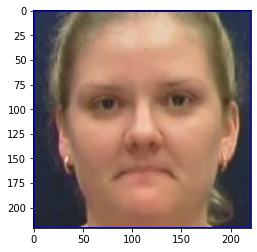

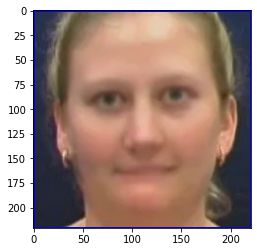

In [ ]:
real_crop = imageio.imread(real_img)
plt.imshow(real_crop)
plt.show()

fake_crop = imageio.imread(fake_img)
plt.imshow(fake_crop)
plt.show()

Brute-Force Matching with ORB Descriptors

In [ ]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1_orb, des1_orb = orb.detectAndCompute(real_crop,None)
kp2_orb, des2_orb = orb.detectAndCompute(fake_crop,None)

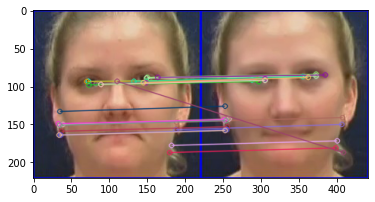

In [ ]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches_orb = bf.match(des1_orb, des2_orb)

# Sort them in the order of their distance.
matches_orb = sorted(matches_orb, key = lambda x:x.distance)

# Draw first 10 matches.
img_orb = cv2.drawMatches(real_crop, kp1_orb, fake_crop, kp2_orb, matches_orb, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) # matches[:10]
plt.imshow(img_orb)
plt.show()

Brute-Force Matching with SIFT Descriptors and Ratio Test

In [ ]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1_sift, des1_sift = sift.detectAndCompute(real_crop, None)
kp2_sift, des2_sift = sift.detectAndCompute(fake_crop, None)


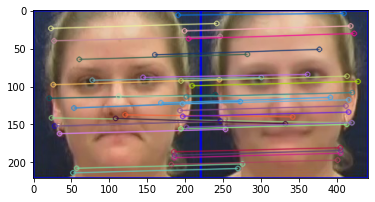

In [ ]:
# BFMatcher with default params
bf2 = cv2.BFMatcher()
matches_sift = bf2.knnMatch(des1_sift, des2_sift, k=2)

# Apply ratio test
good = []
for m,n in matches_sift:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img_sift = cv2.drawMatchesKnn(real_crop, kp1_sift, fake_crop, kp2_sift, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_sift)
plt.show()

FLANN based Matcher

In [ ]:
# For SIFT, SURF
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

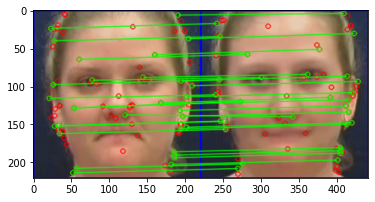

In [ ]:
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches_flann = flann.knnMatch(des1_sift, des2_sift, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches_flann))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches_flann):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img_flann = cv2.drawMatchesKnn(real_crop, kp1_sift, fake_crop, kp2_sift, matches_flann, None, **draw_params)
plt.imshow(img_flann)
plt.show()

Compute Structural Similarity Index (SSIM) between two images to compare how similar they are to each other.

SSIM: 0.7421772519006204


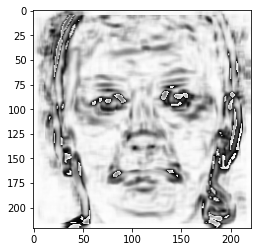

In [ ]:
from skimage.metrics import structural_similarity
import imutils

# Convert the images to grayscale
grayA = cv2.cvtColor(real_crop, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(fake_crop, cv2.COLOR_BGR2GRAY)

# Compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = structural_similarity(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")

# Print the score
print("SSIM: {}".format(score))

# Show the difference image
plt.imshow(diff, cmap = 'gray')
plt.show()

In [ ]:
# Threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 25,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(cnts)

In [ ]:
real_crop2 = real_crop.copy()
fake_crop2 = fake_crop.copy()

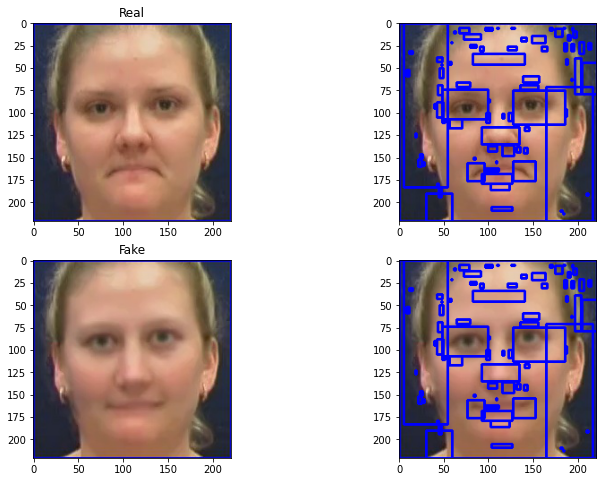

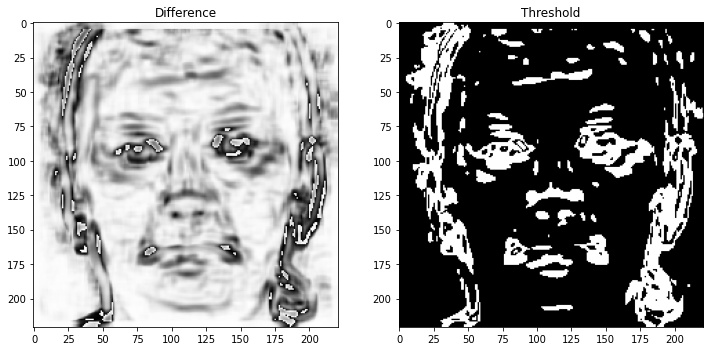

In [ ]:
# loop over the contours
for c in cnts:
# compute the bounding box of the contour and then draw the
# bounding box on both input images to represent where the two
# images differ
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(real_crop2, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.rectangle(fake_crop2, (x, y), (x + w, y + h), (0, 0, 255), 2)
 

fig = plt.figure(figsize=(12, 8))

fig.add_subplot(2, 2, 1)
plt.imshow(real_crop)
plt.title("Real")
fig.add_subplot(2, 2, 2)
plt.imshow(real_crop2)
fig.add_subplot(2, 2, 3)
plt.imshow(fake_crop)
plt.title("Fake")
fig.add_subplot(2, 2, 4)
plt.imshow(fake_crop2)
plt.show()

fig = plt.figure(figsize=(12, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(diff, cmap = 'gray')
plt.title("Difference")
fig.add_subplot(1, 2, 2)
plt.imshow(thresh, cmap = 'gray')
plt.title("Threshold")
plt.show()

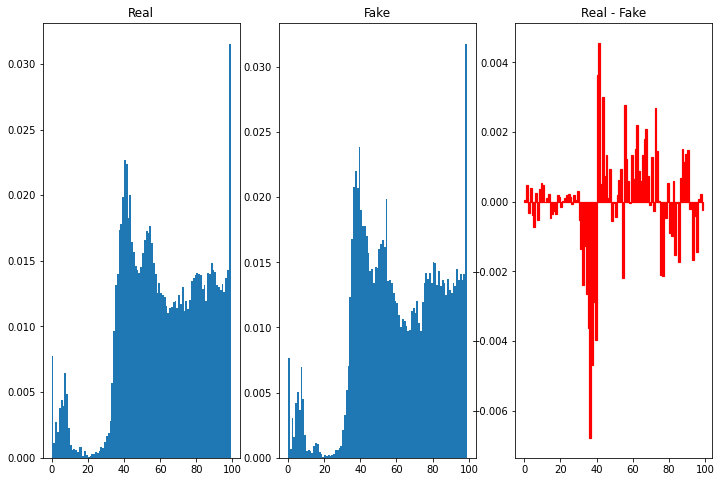

In [ ]:
# histograms
fig, ax = plt.subplots(1,2,figsize=(12, 8))

plt.subplot(131)
plot1=plt.hist(real_crop.ravel(), bins=list(range(100)),
density=True)
plt.title("Real")

plt.subplot(132)
plot2=plt.hist(fake_crop.ravel(), bins=list(range(100)),
density=True) 
plt.title("Fake")

plt.subplot(133)
diff=plt.bar(list(range(99)), height=list(plot1[0]-plot2[0]), edgecolor='red', 
             linewidth=1.2, color='red', width = 1, align = 'edge') 
plt.title("Real - Fake")
plt.show()


plt.show()

## Define Features

**Objective**

From the above methods that compare images, select those that you can use as features. 

One feature should not be too large and should be representative enough for later classification. 

Also, the features are extracted from each frame (or a face) independently, which means there is no reference image to compare to. 
The trick, therefore, is to synthesize that reference. One way to do it is to create a **blurred version of the same image** and compute features between our image and its blurred version. 

Store computed features in **HDF5 **format.


**Workflow**

Some point to consider:
You need to use features that would look different for original faces and Deepfake faces.

You can take features from the matching and image similarity methods you have explored. Histograms could be helpful too.

\\
The most important point to understand here is that during feature computation, the system can only see one video at a time. It means the **features should be computed for each face independently**, i.e., given one image, and you should be able to produce a set of values that describes that image well.

If a particular method of image similarity that you would like to use for feature computation requires two input images (usually reference and probe), then you can use a **trick **to make this method still work even though you have only one image (and no reference). 

You can create a second image artificially by blurring your probe image with Gausssian blur. Then, compute the similarity by using your image and its blurred version.


Besides **Structural Similarity Index (SSIM) computed using the image and its blurred version**, you can also consider the following features (also computed using the image and its blurred version): 
* Mean squared error (MSE), 
* peak signal-to-noise ratio (PSNR), and 
* average difference between the image and its blurred version. 


You can also **add a histogram of the image** or **the histogram of the difference** between the image and its blurred version.


In the end, there **should not be more than 300 values** in the feature vector that you would compute for one image (face). 

Typically, you can aim to have **from 40 to 150 feature values** per image.


**Extract features for a frame (face) and store them in HDF5 format**, which is a good way to store numpy arrays. For a given facial image, compute features and then save the features in HDF5 file. You do not need to save the image as HDF5 files; just features is good enough. The resulting HDF5 file should contain one feature vector for this image.

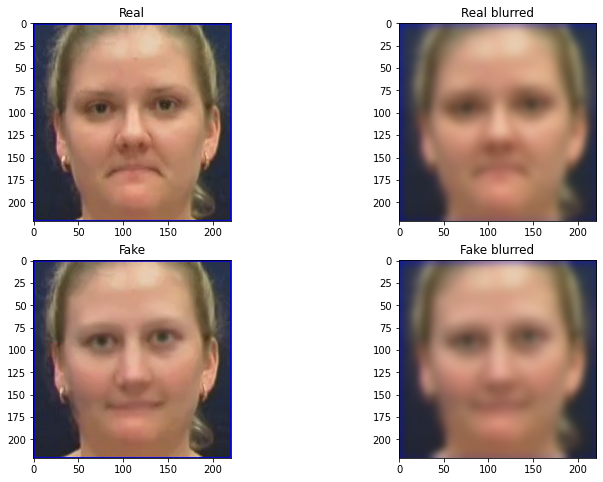

In [ ]:
blur_real = cv2.GaussianBlur(real_crop,(25,25),0)
blur_fake = cv2.GaussianBlur(fake_crop,(25,25),0)

fig = plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(real_crop)
plt.title('Real')
plt.subplot(222)
plt.imshow(blur_real)
plt.title('Real blurred')

plt.subplot(223)
plt.imshow(fake_crop)
plt.title('Fake')
plt.subplot(224)
plt.imshow(blur_fake)
plt.title('Fake blurred')

plt.show()

Features for the real image

SSIM: 0.8274724811670346


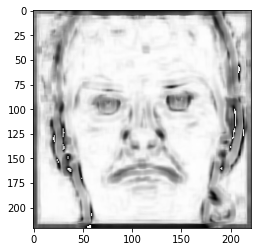

In [ ]:
# SSIM for real image

# Convert the images to grayscale
grayA = cv2.cvtColor(real_crop, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(blur_real, cv2.COLOR_BGR2GRAY)

# Compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score_real, diff_real) = structural_similarity(grayA, grayB, full=True)
diff_real = (diff_real * 255).astype("uint8")

# Print the score
print("SSIM: {}".format(score_real))

# Show the difference image
plt.imshow(diff_real, cmap = 'gray')
plt.show()

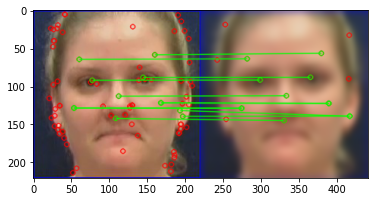

In [ ]:
# FLANN 

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1_sift_real, des1_sift_real = sift.detectAndCompute(real_crop, None)
kp2_sift_real, des2_sift_real = sift.detectAndCompute(blur_real, None)

# For SIFT, SURF
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches_flann_real = flann.knnMatch(des1_sift_real, des2_sift_real, k=2)

# Need to draw only good matches, so create a mask
matchesMask_real = [[0,0] for i in range(len(matches_flann_real))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches_flann_real):
    if m.distance < 0.7*n.distance:
        matchesMask_real[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask_real,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img_flann_real = cv2.drawMatchesKnn(real_crop, kp1_sift_real, blur_real, kp2_sift_real, matches_flann_real, None, **draw_params)
plt.imshow(img_flann_real)
plt.show()

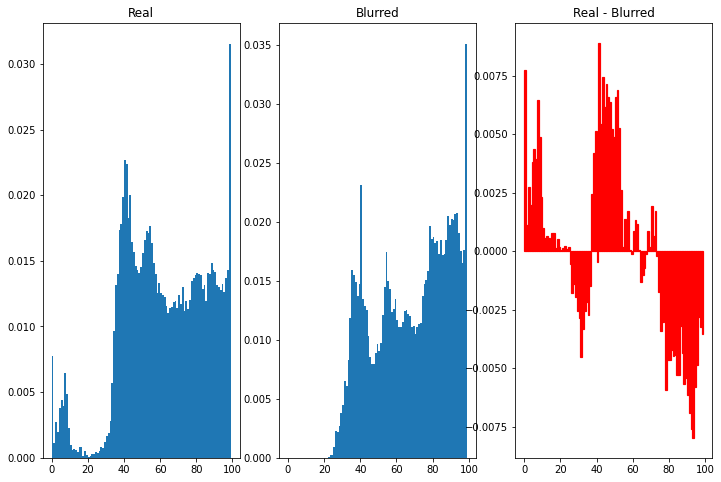

In [ ]:
# histograms
fig, ax = plt.subplots(1,2,figsize=(12, 8))

plt.subplot(131)
plot1=plt.hist(real_crop.ravel(), bins=list(range(100)),
density=True)
plt.title("Real")

plt.subplot(132)
plot2=plt.hist(blur_real.ravel(), bins=list(range(100)),
density=True)
plt.title("Blurred")

plt.subplot(133)
diff=plt.bar(list(range(99)), height=list(plot1[0]-plot2[0]), edgecolor='red', 
             linewidth=1.2, color='red', width = 1, align = 'edge') 
plt.title("Real - Blurred")
plt.show()


plt.show()

In [ ]:
features_real = [matches_flann_real, plot1[0]-plot2[0]]
features_real = [item for sublist in features_real for item in sublist]
features_real.append(score_real)

print("Total features: {}".format(len(features_real)))

Total features: 184


Features for the fake image

SSIM: 0.8530525148217585


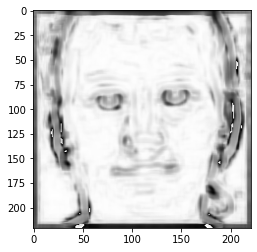

In [ ]:
# SSIM fro fake image

# Convert the images to grayscale
grayA = cv2.cvtColor(fake_crop, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(blur_fake, cv2.COLOR_BGR2GRAY)

# Compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score_fake, diff_fake) = structural_similarity(grayA, grayB, full=True)
diff_fake = (diff_fake * 255).astype("uint8")

# Print the score
print("SSIM: {}".format(score_fake))

# Show the difference image
plt.imshow(diff_fake, cmap = 'gray')
plt.show()

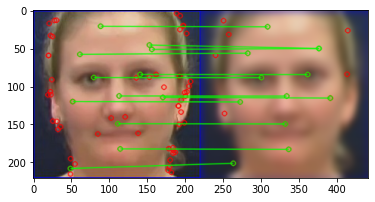

In [ ]:
# find the keypoints and descriptors with SIFT
kp1_sift_fake, des1_sift_fake = sift.detectAndCompute(fake_crop, None)
kp2_sift_fake, des2_sift_fake = sift.detectAndCompute(blur_fake, None)

matches_flann_fake = flann.knnMatch(des1_sift_fake, des2_sift_fake, k=2)

# Need to draw only good matches, so create a mask
matchesMask_fake = [[0,0] for i in range(len(matches_flann_fake))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches_flann_fake):
    if m.distance < 0.7*n.distance:
        matchesMask_fake[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask_fake,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img_flann_fake = cv2.drawMatchesKnn(fake_crop, kp1_sift_fake, blur_fake, kp2_sift_fake, matches_flann_fake, None, **draw_params)
plt.imshow(img_flann_fake)
plt.show()

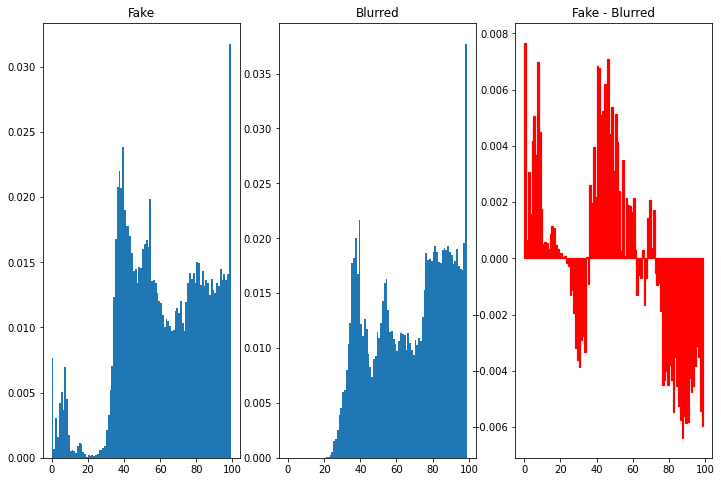

In [ ]:
# histograms
fig, ax = plt.subplots(1,2,figsize=(12, 8))

plt.subplot(131)
plot1=plt.hist(fake_crop.ravel(), bins=list(range(100)),
density=True)
plt.title("Fake")

plt.subplot(132)
plot2=plt.hist(blur_fake.ravel(), bins=list(range(100)),
density=True)
plt.title("Blurred")

plt.subplot(133)
diff=plt.bar(list(range(99)), height=list(plot1[0]-plot2[0]), edgecolor='red', 
             linewidth=1.2, color='red', width = 1, align = 'edge') 
plt.title("Fake - Blurred")
plt.show()


plt.show()

In [ ]:
features_fake = [matches_flann_fake, plot1[0]-plot2[0]]
features_fake = [item for sublist in features_fake for item in sublist]
features_fake.append(score_fake)

print("Total features: {}".format(len(features_fake)))

Total features: 166
